## 5.0 Load the preprocessed data

In [40]:
import pandas as pd
import sqlite3

# Path relative to the notebook
db_path = "../data/processed/rt_iot2022_processed.db"

# Load dataframe from the first table
with sqlite3.connect(db_path) as conn:
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
    table_name = tables.iloc[0, 0]
    df = pd.read_sql(f'SELECT * FROM "{table_name}";', conn)   # <-- hier df

print(f"Loaded from {db_path} | table: {table_name}")
print("Shape:", df.shape)
display(df.head())


Loaded from ../data/processed/rt_iot2022_processed.db | table: flows_clean
Shape: (18061, 20)


,proto,service,flow_duration,fwd_pkts_tot,down_up_ratio,fwd_header_size_tot,bwd_header_size_min,flow_syn_flag_count,flow_rst_flag_count,flow_ack_flag_count,fwd_pkts_payload_tot,fwd_pkts_payload_avg,bwd_pkts_payload_max,bwd_pkts_payload_avg,flow_pkts_payload_avg,fwd_iat_min,bwd_iat_min,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes
0,tcp,mqtt,32.011598,9,0.555556,296,32,2,1,13,76,8.444444,23,6.4,7.714286,761.985779,4438.877106,3.0,1.666667,25.333333
1,tcp,mqtt,31.883584,9,0.555556,296,32,2,1,13,76,8.444444,23,6.4,7.714286,247.001648,4214.048386,3.0,1.666667,25.333333
2,tcp,mqtt,32.124053,9,0.555556,296,32,2,1,13,74,8.222222,21,6.0,7.428571,283.956528,2456.903458,3.0,1.666667,24.666667
3,tcp,mqtt,31.961063,9,0.555556,296,32,2,1,13,74,8.222222,21,6.0,7.428571,288.963318,3933.906555,3.0,1.666667,24.666667
4,tcp,mqtt,31.902362,9,0.555556,296,32,2,1,13,76,8.444444,23,6.4,7.714286,387.907028,3005.027771,3.0,1.666667,25.333333


## 6.0 Leakage & correlation sanity check

We run a quick safety scan before modelling:

Define features: split categorical (proto, service) and numeric features; exclude the target flow_duration.

Correlation screen: compute correlations (numeric features only) with the target. We flag anything with |r| > 0.98 as likely leakage.

In [41]:
#Config
CONFIG = {"target": "flow_duration"}  # zet hier je target vast
target = CONFIG["target"]

# Feature lists
cat_features = [c for c in ["proto", "service"] if c in df.columns]
num_features = [c for c in df.columns if c not in cat_features + [target]]

# Leakage check: flags op per-second achtige features
def warn_possible_leakage(cols):
    bad = [c for c in cols if ("per_sec" in c.lower()) or ("per_second" in c.lower())]
    if bad:
        print("Potential leakage-like rate features still present:", bad)

warn_possible_leakage(df.columns)

# Correlation screen
numeric_cols = df[num_features + [target]].select_dtypes(include="number").columns.tolist()

if target not in numeric_cols:
    raise ValueError(f"Target '{target}' is not numeric after selection. Check dtypes.")

if len(numeric_cols) > 1:
    corrs = df[numeric_cols].corr(numeric_only=True)[target].sort_values(ascending=False)
    suspicious = corrs[abs(corrs) > 0.98].drop(labels=[target], errors="ignore")
    if len(suspicious) > 0:
        print("Features extremely correlated with target — verify not leaking info:\n", suspicious)
else:
    print(" Not enough numeric features to compute correlations.")


### Conclusion. Results of the safety scan

- Leakage-like features: None detected (no per_sec / per_second columns present).
- Target dtype: Numeric (OK for correlation and regression).
- Extreme correlations (|r| > 0.98) with flow_duration: None found.

**What this means:**
The current feature set looks safe to proceed. We didn’t find obvious leakage signals or “too-good-to-be-true” correlations with the target.

### 6.1 visualize the datasset
Before training models, it is important to understand the structure of our dataset

We plot a histogram of flow_duration to see how the target variable is distributed. This helps us check for skewness or extreme outliers that might affect regression performance.

We also create bar charts for categorical features (proto and service) to understand which communication protocols and services dominate the dataset. These insights tell us how balanced or imbalanced our dataset is, which is important for both model training and interpretation.

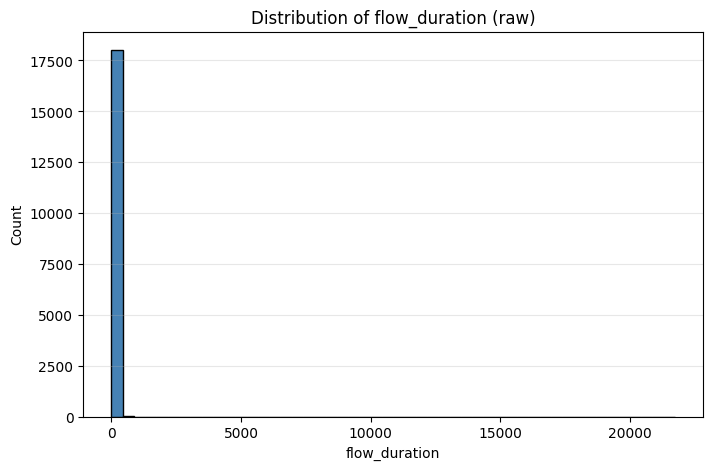

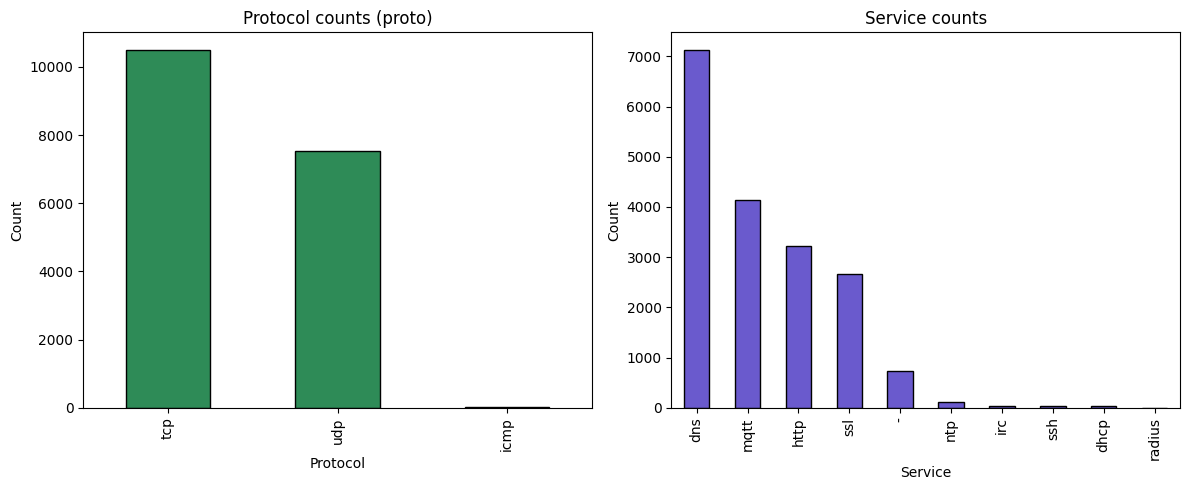

In [42]:
import matplotlib.pyplot as plt

# Histogram flow_duration
plt.figure(figsize=(8,5))
plt.hist(df["flow_duration"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of flow_duration (raw)")
plt.xlabel("flow_duration")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Bar charts for categorical features
fig, axes = plt.subplots(1, 2, figsize=(12,5))

df["proto"].value_counts().plot(kind="bar", ax=axes[0], color="seagreen", edgecolor="black")
axes[0].set_title("Protocol counts (proto)")
axes[0].set_xlabel("Protocol")
axes[0].set_ylabel("Count")

df["service"].value_counts().plot(kind="bar", ax=axes[1], color="slateblue", edgecolor="black")
axes[1].set_title("Service counts")
axes[1].set_xlabel("Service")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Conclusion

- flow_duration distribution: The histogram shows a strong right-skew. Most flows are very short, while a small number of flows last much longer. This imbalance confirms that applying a log transformation on the target is useful to stabilize variance and make regression easier.

- The dataset is dominated by TCP and UDP traffic, with very few ICMP flows. This imbalance should be kept in mind when interpreting model performance.

- Some services like DNS, MQTT, and HTTP are much more common, while others such as IRC, SSH, DHCP, RADIUS appear rarely. Models might learn patterns strongly tied to the most frequent services, so service imbalance could influence predictions.

**Conclusion:**
The dataset has a skewed target and imbalanced categorical features. We should use a log transform on flow_duration before modelling.

### 6.3 log-transformation of the target

Why apply a log transformation to the target?

The raw distribution of flow_duration is very skewed:
- Most network sessions are very short.
- A small number of flows last extremely long.

This imbalance makes it hard for regression models to learn effectively, because very long flows dominate the error. By applying a log1p transformation (log(1+x)), we compress the long tail and create a more balanced distribution. This helps the model handle both short and long sessions better.

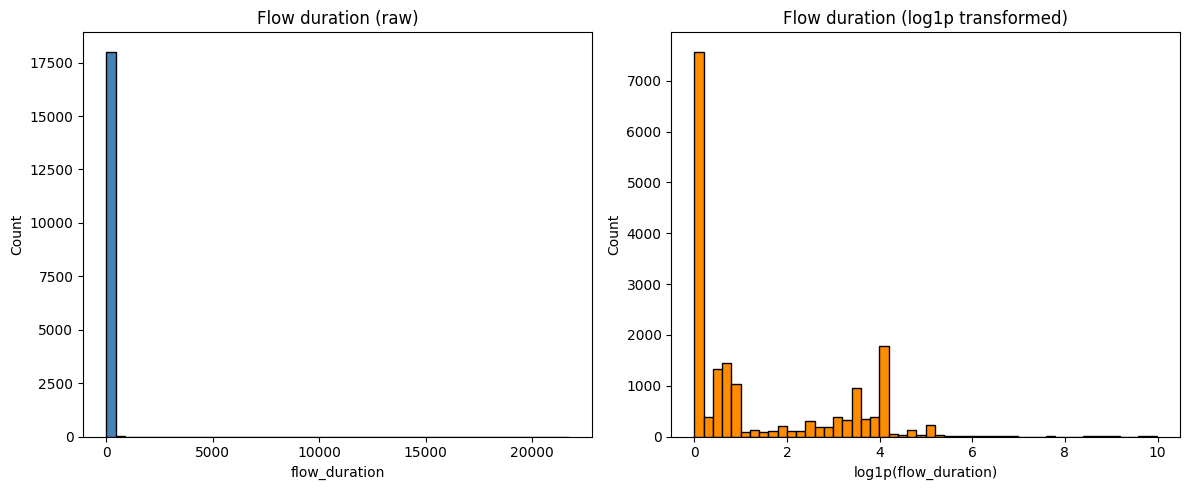

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform of the target
df["flow_duration_log"] = np.log1p(df["flow_duration"])  # log(1+x) voorkomt log(0) fout

# Plot raw vs log distribution
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Raw
axes[0].hist(df["flow_duration"], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Flow duration (raw)")
axes[0].set_xlabel("flow_duration")
axes[0].set_ylabel("Count")

# Log-transformed
axes[1].hist(df["flow_duration_log"], bins=50, color="darkorange", edgecolor="black")
axes[1].set_title("Flow duration (log1p transformed)")
axes[1].set_xlabel("log1p(flow_duration)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Conclusion

Raw flow_duration (left): Almost all flows are clustered close to zero, while a few extreme outliers stretch the scale. This shows strong right-skewness.

Log-transformed flow_duration (right): The distribution is much more balanced. We can now see meaningful variation across short, medium, and longer flows.

Conclusion:
We will use log1p-transformed flow_duration during training to stabilize variance and improve regression performance. Predictions will be converted back to the original scale for reporting, so stakeholders see results in real units (seconds).

## 7.0 Train/Test split + Stratified K-Fold on target bins

We create an honest hold-out test set and do Stratified K-Fold only on the training data.

Because flow_duration is continuous, we first make quantile bins (e.g., 10 bins) so stratification keeps a similar target distribution across folds. This reduces variance in cross-validation scores and gives a fairer model comparison.

Using 10 target bins for full-dataset stratification check
Fold 1: train=14448  val= 3613  train_mean=24.651  val_mean=25.722
Fold 2: train=14449  val= 3612  train_mean=25.760  val_mean=21.282
Fold 3: train=14449  val= 3612  train_mean=26.101  val_mean=19.919
Fold 4: train=14449  val= 3612  train_mean=24.243  val_mean=27.352
Fold 5: train=14449  val= 3612  train_mean=23.569  val_mean=30.050
Train shape: (14448, 19) | Test shape: (3613, 19)
Using 10 target bins for stratified CV on training data
Fold 1: train=11558  val= 2890  train_mean=26.085  val_mean=27.670
Fold 2: train=11558  val= 2890  train_mean=25.704  val_mean=29.194
Fold 3: train=11558  val= 2890  train_mean=25.965  val_mean=28.149
Fold 4: train=11559  val= 2889  train_mean=26.141  val_mean=27.447
Fold 5: train=11559  val= 2889  train_mean=28.115  val_mean=19.547


/Users/esthervanhelmont/Library/Python/3.9/lib/python/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


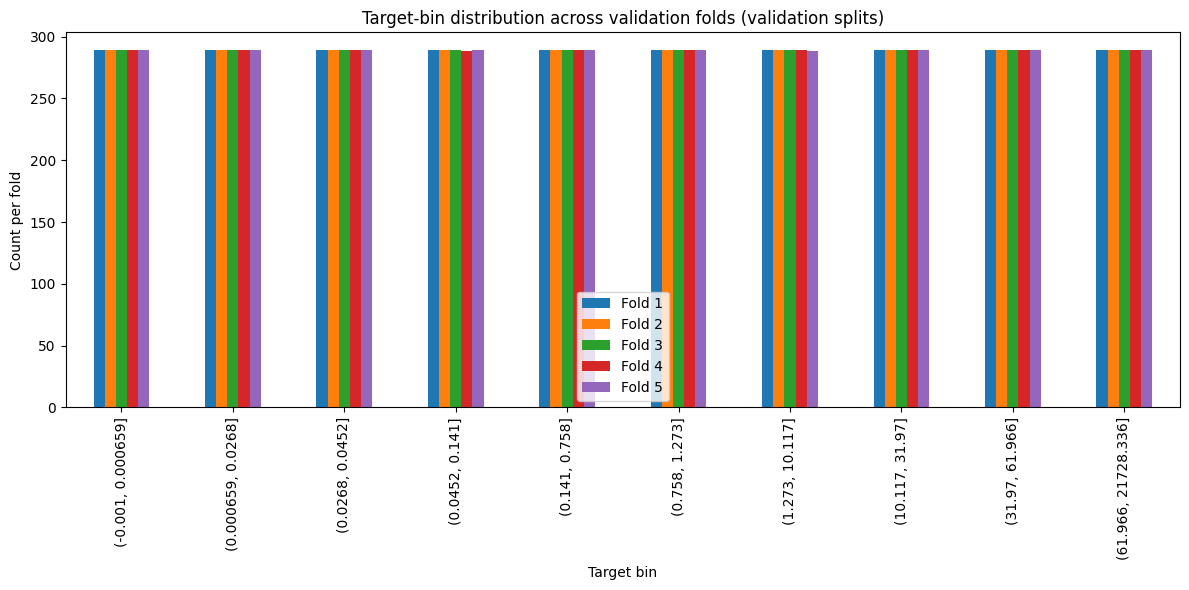

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# settings
RANDOM_STATE = 42
N_SPLITS = 5
N_BINS_FULL = 10     # bins for the quick, full-dataset check
N_BINS_TRAIN = 10    # bins for stratified CV on the training set
TARGET_COL = "flow_duration"

# helpers
def make_bins(y_vec, q, min_per_bin):
    """
    Create quantile bins for continuous targets.
    If any bin is too small, reduce q until each bin has at least min_per_bin samples.
    """
    q_try = q
    while q_try >= 2:
        bins = pd.qcut(y_vec, q=q_try, duplicates="drop")
        if bins.value_counts().min() >= min_per_bin:
            return bins
        q_try -= 1
    return pd.qcut(y_vec, q=2, duplicates="drop")

# ensure target is numeric & drop missing 
y_raw = pd.to_numeric(df[TARGET_COL], errors="coerce")
mask = y_raw.notna() & np.isfinite(y_raw)
df_clean = df.loc[mask].reset_index(drop=True)
y_clean = y_raw.loc[mask].reset_index(drop=True)

# quick stratification check on the full dataset
y_bins_full = make_bins(y_clean, q=N_BINS_FULL, min_per_bin=N_SPLITS)
y_bins_full_codes = y_bins_full.cat.codes

skf_full = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {y_bins_full.nunique()} target bins for full-dataset stratification check")
for fold, (tr_idx, va_idx) in enumerate(skf_full.split(df_clean, y_bins_full_codes), 1):
    print(f"Fold {fold}: train={len(tr_idx):5d}  val={len(va_idx):5d}  "
          f"train_mean={y_clean.iloc[tr_idx].mean():.3f}  val_mean={y_clean.iloc[va_idx].mean():.3f}")

# train/test split (hold-out for honest final evaluation)
drop_cols = [c for c in [TARGET_COL, "flow_duration_log"] if c in df_clean.columns]
X = df_clean.drop(columns=drop_cols)
y = y_clean.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# bins for stratification on TRAIN ONLY
y_bins_train = make_bins(y_train, q=N_BINS_TRAIN, min_per_bin=N_SPLITS)
y_bins_train_codes = y_bins_train.cat.codes

# Stratified K-Fold object for CV on training set
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {y_bins_train.nunique()} target bins for stratified CV on training data")
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_bins_train_codes), 1):
    print(f"Fold {fold}: train={len(tr_idx):5d}  val={len(va_idx):5d}  "
          f"train_mean={y_train.iloc[tr_idx].mean():.3f}  val_mean={y_train.iloc[va_idx].mean():.3f}")

# visualization: distribution of target bins across validation folds (training only) 
fold_bins = []
for _, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_bins_train_codes), 1):
    fold_bins.append(pd.Series(y_bins_train.iloc[va_idx]).value_counts().sort_index())

fold_bins_df = pd.DataFrame(fold_bins).T.fillna(0)

ax = fold_bins_df.plot(kind="bar", figsize=(12,6))
ax.set_title("Target-bin distribution across validation folds (validation splits)")
ax.set_xlabel("Target bin")
ax.set_ylabel("Count per fold")
plt.legend([f"Fold {i+1}" for i in range(len(fold_bins))])
plt.tight_layout()
plt.show()


### Conclusion
The train/test split was successful:
- Training set: 14,448 rows (19 features)
- Test set: 3,613 rows (19 features)

Stratified K-Fold (5 folds, 10 bins) maintained a balanced distribution of the target flow_duration across folds:

- Each fold has similar counts per bin (see bar chart).
- Fold sizes are stable (~11.5k train / ~2.9k validation).
- Target means vary slightly across folds (19–30), which is expected in real-world continuous data.

**Interpretation:**
The folds are balanced enough to ensure fair cross-validation. Each validation set contains short, medium, and long flows in proportions similar to the training data.
This setup gives us a reliable foundation for model training and hyperparameter tuning, while the hold-out test set ensures we can report an honest final performance.

## Preprocessing pipeline

We standardize how features are prepared before every model:

- Categoricals (proto, service) → One-Hot Encode with rare-category handling.
- Numericals (all other non-target columns) → Median imputation + Robust scaling (less sensitive to outliers).
- Keep everything inside a ColumnTransformer so that CV and all models see the exact same transformations. This reduces data leakage and makes results reproducible.

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

TARGET_COL = "flow_duration"

# derive feature lists from your current training frame
cat_features = [c for c in ["proto", "service"] if c in X_train.columns]
num_features = [c for c in X_train.columns if c not in cat_features]

print("Categorical:", cat_features)
print("Numeric (#):", len(num_features))

# transformers
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=10))  # group rare cats
])

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler())
])

# column transformer
preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_features),
        ("num", num_pipe, num_features),
    ],
    remainder="drop"
)

# quick fit/transform sanity check
Xt_sample = preprocess.fit_transform(X_train)
print("Transformed shape:", Xt_sample.shape)

# (optional) get feature names for inspection
def get_feature_names(preprocessor):
    out = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            oh = trans.named_steps["onehot"]
            oh_names = oh.get_feature_names_out(cols)
            out.extend(oh_names)
        else:
            out.extend(cols if isinstance(cols, list) else list(cols))
    return np.array(out, dtype=object)

try:
    feature_names = get_feature_names(preprocess)
    print("Feature names preview:", feature_names[:10])
except Exception as e:
    print("Note: feature names available after fitting tree/linear models that expose them.", e)


Categorical: ['proto', 'service']
Numeric (#): 17
Transformed shape: (14448, 30)
Feature names preview: ['proto_icmp' 'proto_tcp' 'proto_udp' 'service_-' 'service_dhcp'
 'service_dns' 'service_http' 'service_irc' 'service_mqtt' 'service_ntp']


### Conclusion

Categorical features: proto and service were correctly one-hot encoded. Rare categories are grouped automatically.

- Numeric features: 17 columns were imputed (median) and scaled with RobustScaler to reduce the effect of outliers.

- Transformed feature space: Training data (14,448 rows) expanded to 30 engineered features after preprocessing.

- Feature names preview confirms that both protocol and service were expanded into clear dummy variables (proto_tcp, service_dns, service_mqtt, …).

**Interpretation:**
The preprocessing pipeline is working as intended: it delivers a clean, consistent feature matrix that models can directly use. This ensures reproducibility, reduces leakage risk, and makes results across different models comparable.

## Baseline model

We train a simple baseline to establish a performance floor:

- Uses our preprocessing pipeline (one-hot + robust scaling).
- Fits a DummyRegressor (median) on log1p(flow_duration) to handle skew.

Evaluates with Stratified K-Fold on the training set and reports metrics in original units (inverse log back-transform).

This gives us a fair benchmark.

In [47]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# helpers (version-safe)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def cv_score_model(estimator, X, y_raw, skf, y_bins_codes):
    """
    Cross-validated scores using log1p target for fitting,
    and back-transforming predictions to original units for metrics.
    """
    y_log = np.log1p(y_raw.values)
    rmses, maes, r2s = [], [], []
    for tr_idx, va_idx in skf.split(X, y_bins_codes):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_log = y_log[tr_idx]
        y_va = y_raw.iloc[va_idx].values

        est = estimator
        est.fit(X_tr, y_tr_log)

        pred_log = est.predict(X_va)
        pred = np.expm1(pred_log)

        rmses.append(rmse(y_va, pred))
        maes.append(mae(y_va, pred))
        r2s.append(r2_score(y_va, pred))
    return {"rmse": float(np.mean(rmses)), "mae": float(np.mean(maes)), "r2": float(np.mean(r2s))}

# baseline pipeline: preprocess → Dummy(median)
baseline = Pipeline([
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="median")),
])

# cross-validated baseline on training set
baseline_cv = cv_score_model(baseline, X_train, y_train, skf, y_bins_train_codes)
print("Baseline CV (original units):", baseline_cv)

# hold-out estimate (fit on all train, evaluate on test)
baseline.fit(X_train, np.log1p(y_train.values))
y_pred_test = np.expm1(baseline.predict(X_test))

baseline_test = {
    "rmse": rmse(y_test.values, y_pred_test),
    "mae":  mae(y_test.values, y_pred_test),
    "r2":   r2_score(y_test.values, y_pred_test)
}
print("Baseline Test (original units):", baseline_test)


Baseline CV (original units): {'rmse': 342.24204830042066, 'mae': 26.273084799250757, 'r2': -0.007905042663342155}
Baseline Test (original units): {'rmse': np.float64(114.69200038846853), 'mae': 18.587997236783902, 'r2': -0.025140312096777695}


### Conclusion
The baseline model is a very simple predictor: it always guesses the same typical duration for every network session, no matter what features we give it.

- As expected, this leads to large errors (RMSE ≈ 342, MAE ≈ 26).
- The negative R² score means the model is no better than guessing the average.

This is normal for a baseline. It does not aim to be accurate, but rather sets a reference point. Any smarter model we build should perform much better than this, otherwise our approach is not adding value.

**Interpretation:** 

The baseline (median predictor) cannot explain variance in flow_duration (negative R² values).

Errors (RMSE/MAE) are large compared to the target scale, which is expected because the model always predicts the same value regardless of input features.

This confirms the baseline serves its role: it provides a floor. Any useful regression model should beat these numbers significantly.

## Model suite & hyperparameter search

### Conclusion

## Error analysis & diagnostics

### Conclusion

## Final training and hold‑out evaluation

### Conclusion

## Save ML

### Conclusion